<a id="top"></a>
# ALOS Viewer
<p style= "color:red; font-size:30px">
<b>ALOS Data Analysis Notebook</b>
</style>

*Notebook compatible with DE Africa Collection 1 Sandbox

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
%matplotlib inline
# Ignore warnings (from NDVI)
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
# Set a legible font size for matplotlib plots.
plt.rcParams.update({'font.size': 16})

# Import the datacube and the API
import datacube
import sys
import pandas as pd
from odc.ui import DcViewer

import numpy as np
import xarray as xr
import pandas as pd

from xarray.ufuncs import fabs
from matplotlib.colors import LinearSegmentedColormap
from xarray.ufuncs import isfinite

#import DE Africa script
sys.path.append('../Scripts')
from deafrica_plotting import display_map


#import DCAL utility scripts
sys.path.append('../DCAL_utils')
from plotter_utils import figure_ratio, retrieve_or_create_fig_ax, intersection_threshold_plot, month_names_long
from dc_rgb import rgb
from dc_time import _n64_to_datetime
from raster_filter import stats_filter_2d


In [2]:
dc = datacube.Datacube(app="Alos_viewer")

## list ALOS product measurements

In [3]:
product = "alos_palsar_mosaic"

measurements = dc.list_measurements()
measurements.loc[product]

aliases  dtype  \
measurement                                                     
hh                                                [hh]  int16   
hv                                                [hv]  int16   
date                                            [date]  int16   
linci        [local incidence angle, linci, incidence]  uint8   
mask                                            [mask]  uint8   

                                              flags_definition   name nodata  \
measurement                                                                    
hh                                                         NaN     hh      0   
hv                                                         NaN     hv      0   
date                                                       NaN   date      0   
linci                                                      NaN  linci      0   
mask         {'category': {'bits': [0, 1, 2, 3, 4, 5, 6, 7]...   mask      0   

            units  
measurement        
hh              1  
hv              1  
date            1  
linci           1  
mask            1

## <span id="extents">View the Extent of Data Avalibility in the Cube [&#9652;](#top)</span>

Change the year specified below to view data avalibility for different years

In [4]:
DcViewer(dc=dc, 
         time='2017',
         center=(0.565, 38.007),
         zoom=6)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

Specify latitude and longitude bounds of an interesting area and specify the time range for which to load avalible data


In [5]:
# Okosombo - Volta River (diverse region)
lat = (6.1064, 5.7854)
lon = (0.4607, 1.0094)

time_extents = ('2007-07-02', '2017-07-02')

**Visualize the selected area**

In [6]:
display_map(x=lon, y=lat)

## <span id="load_data">Load Data from the Data Cube [&#9652;](#top)</span>

In [7]:
# Load the data
dataset = dc.load(product="alos_palsar_mosaic",
                 x=lon,
                 y=lat,
                 time=time_extents)

print(dataset)

<xarray.Dataset>
Dimensions:    (latitude: 1445, longitude: 2470, time: 7)
Coordinates:
  * time       (time) datetime64[ns] 2007-07-02T12:00:00 ... 2017-07-02T12:00:00
  * latitude   (latitude) float64 6.106 6.106 6.106 6.106 ... 5.786 5.786 5.785
  * longitude  (longitude) float64 0.4608 0.461 0.4612 ... 1.009 1.009 1.009
Data variables:
    hh         (time, latitude, longitude) int16 2448 2486 2042 ... 1694 1641
    hv         (time, latitude, longitude) int16 843 1158 1186 ... 285 316 359
    date       (time, latitude, longitude) int16 588 588 588 ... 1228 1228 1228
    linci      (time, latitude, longitude) uint8 36 36 39 43 45 ... 35 35 35 35
    mask       (time, latitude, longitude) uint8 255 255 255 255 ... 50 50 50 50
Attributes:
    crs:      EPSG:4326


## Speckle filtering (optional).
Note that this can take a while. Remove the comments to run this code.
<br>The filter size refers to the number of pixels used in averaging window.
<br> Filter sizes should be odd, such as 3 (for 3x3), 5, 7, etc.

In [8]:

# for time in sar_dataset.time:
#      for data_var in sar_dataset:
#         data_arr = sar_dataset.sel(time=time)[data_var]
#         data_arr.values[:] = stats_filter_2d(data_arr, 'mean', filter_size=3).values

In [9]:
# Creation of a new band (HH/HV = hhhv) for RGB display
dataset['hhhv'] = dataset.hh / dataset.hv

In [10]:
dataset

<xarray.Dataset>
Dimensions:    (latitude: 1445, longitude: 2470, time: 7)
Coordinates:
  * time       (time) datetime64[ns] 2007-07-02T12:00:00 ... 2017-07-02T12:00:00
  * latitude   (latitude) float64 6.106 6.106 6.106 6.106 ... 5.786 5.786 5.785
  * longitude  (longitude) float64 0.4608 0.461 0.4612 ... 1.009 1.009 1.009
Data variables:
    hh         (time, latitude, longitude) int16 2448 2486 2042 ... 1694 1641
    hv         (time, latitude, longitude) int16 843 1158 1186 ... 285 316 359
    date       (time, latitude, longitude) int16 588 588 588 ... 1228 1228 1228
    linci      (time, latitude, longitude) uint8 36 36 39 43 45 ... 35 35 35 35
    mask       (time, latitude, longitude) uint8 255 255 255 255 ... 50 50 50 50
    hhhv       (time, latitude, longitude) float64 2.904 2.147 ... 5.361 4.571
Attributes:
    crs:      EPSG:4326

## <span id="visualize">Visualize Data [&#9652;](#top)</span>

In [11]:

def plot_threshold(ds, band_name, bottom = None , top = None, log_scaled = False, 
                   cmap_name = 'Greys', fig=None, ax=None):
    # Threshold is applied to original data, not log scaled data(if you haven't scaled already)
    _range = "Full {} range: {}-{}".format(band_name, ds[band_name].min().values,ds[band_name].max().values)

    selection = ds[band_name]
    
    my_cmap = plt.cm.get_cmap(cmap_name)
    my_cmap.set_over('r')
    my_cmap.set_under('b')
    
    fig, ax = retrieve_or_create_fig_ax(fig, ax)
    
    selection = 10*np.log10(selection) if log_scaled == True else selection
    
    bottom    = 10*np.log10(bottom)    if log_scaled == True and bottom is not None else bottom
    top       = 10*np.log10(top)       if log_scaled == True and top is not None else top
    
    selection.plot(cmap = my_cmap, vmax =top, vmin = bottom, ax=ax)    
    xlim, ylim = ax.set_xlim(), ax.set_ylim()
    ax.text(min(xlim) + 0.5 * (max(xlim) - min(xlim)),
            min(ylim) + -0.1 * (max(ylim) - min(ylim)),_range, horizontalalignment = "center")

In [12]:

def n64_to_month_and_year(n64):
    datetime_val = _n64_to_datetime(n64)
    return month_names_long[datetime_val.month-1] + ' ' + str(datetime_val.year)

In [13]:
# Show acquisition indices and times.
print("Available acquisition indices and times")
times = dataset.time.values
months = np.array(list(map(n64_to_month_and_year, times)))
pd.DataFrame(dict(times=times, months=months))

Available acquisition indices and times


times     months
0 2007-07-02 12:00:00  July 2007
1 2008-07-02 00:00:00  July 2008
2 2009-07-02 12:00:00  July 2009
3 2010-07-02 12:00:00  July 2010
4 2015-07-02 12:00:00  July 2015
5 2016-07-02 00:00:00  July 2016
6 2017-07-02 12:00:00  July 2017

<p style= "color:blue; font-size:25px">
<b>Single Date Analyses</b>
</style>

In [14]:
# Choose a single acquisition by its index (listed above)
acq_ind_to_show = 6

## Histogram Plots

In [15]:


# Determine a range of values to limit the x axis to for histogram plots.
# This allows the histograms to be more easily compared.
# Use quantiles to avoid extreme outliers.

hist_ds = dataset.isel(time=acq_ind_to_show)[['hh','hv']]
hist_ds = hist_ds.where(isfinite(hist_ds))

min_per_data_var = hist_ds.quantile(0.001).to_array().values
min_val = min_per_data_var[np.isfinite(min_per_data_var)].min()

max_per_data_var = hist_ds.quantile(0.999).to_array().values
max_val = max_per_data_var[np.isfinite(max_per_data_var)].max()

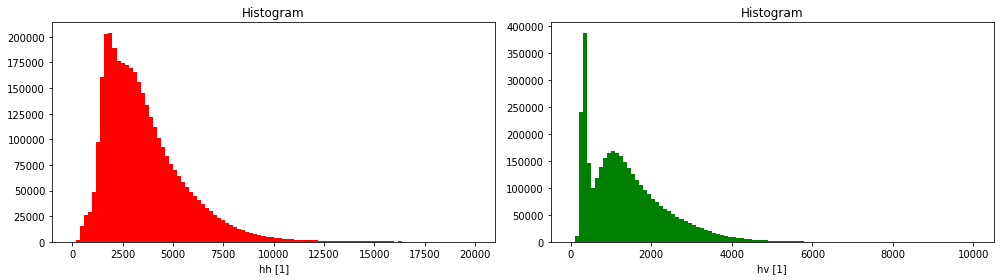

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

dataset.isel(time=acq_ind_to_show).hh.plot.hist(ax=ax[0], bins=100, 
                                                range=(0,20000), facecolor='red')
dataset.isel(time=acq_ind_to_show).hv.plot.hist(ax=ax[1], bins=100, 
                                                range=(0,10000), facecolor='green')

plt.tight_layout()
plt.show()

## Scaling of backscatter amplitude for image outputs

In [17]:
hh = dataset.hh.astype(np.int64); hh_min = hh.min(); hh_max = hh.max()
dataset['hh_amp_8b'] = hh*255/15000
hv = dataset.hv.astype(np.int64); hv_min = hv.min(); hv_max = hv.max()
dataset['hv_amp_8b'] = hv*255/7500
hhhv = dataset.hhhv.astype(np.int64); hhhv_min = hhhv.min(); hhhv_max = hhhv.max()
dataset['hhhv_amp_8b'] = 50*(hh/15000)/(hv/7500)

#### RGB images

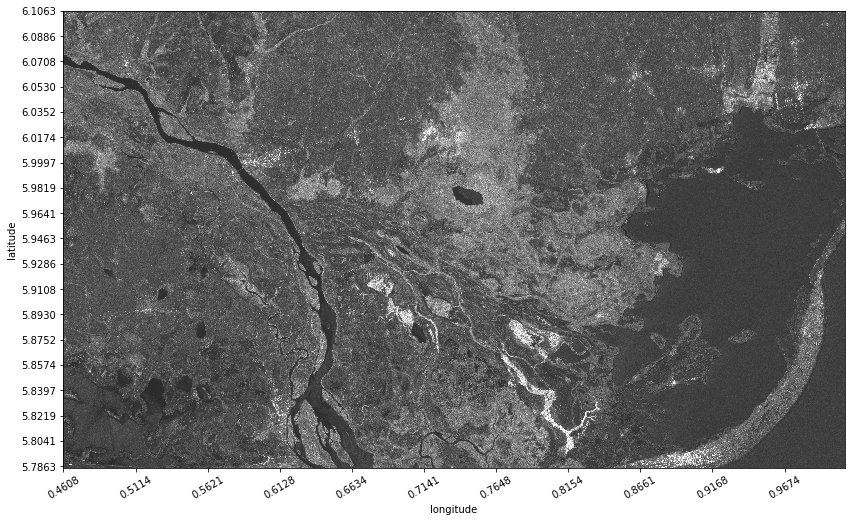

In [18]:
# Scaled HH image
rgb(dataset.isel(time=acq_ind_to_show), 
    bands=['hh_amp_8b','hh_amp_8b','hh_amp_8b'], min_possible=0, max_possible=255, width=14)
plt.show()

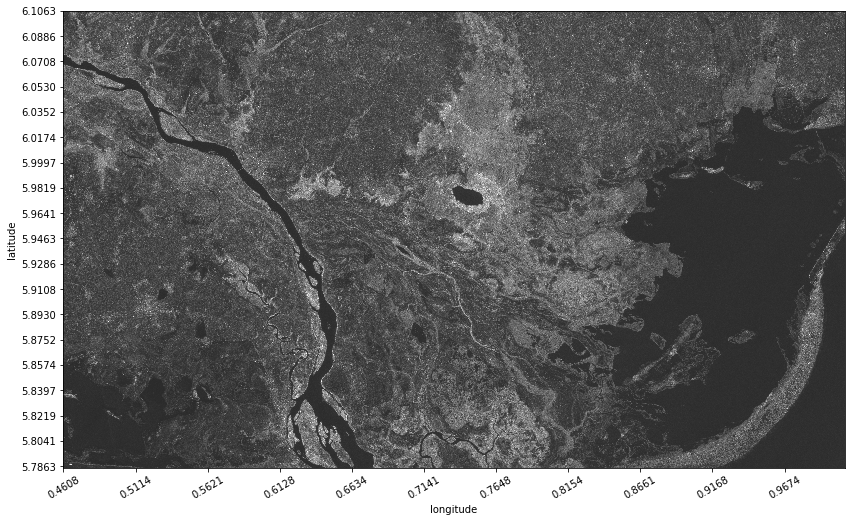

In [19]:
# Scaled VH image
rgb(dataset.isel(time=acq_ind_to_show), 
    bands=['hv_amp_8b','hv_amp_8b','hv_amp_8b'], min_possible=0, max_possible=255, width=14)
plt.show()

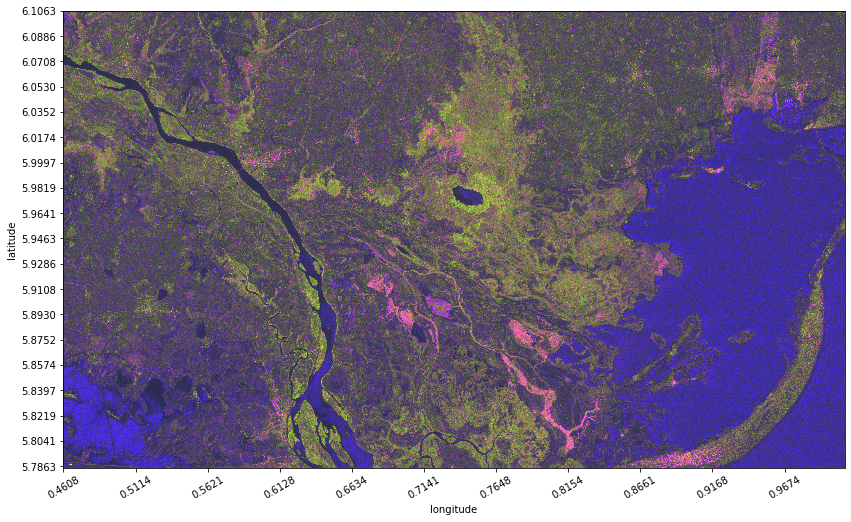

In [20]:
# Scaled RGB (VV, VH, VV/VH)
rgb(dataset.isel(time=acq_ind_to_show), 
    bands=['hh_amp_8b','hv_amp_8b','hhhv_amp_8b'], min_possible = 0, max_possible = 255, width=14)
plt.show()

## Custom RGB
Select the image number and band for each RGB color

In [21]:

def custom_rgb(dataset, rgb_to_data_arr_ind_map, **rgb_kwargs):
    """
    Plots many images with a mapping of the red, green, and blue channels to data variables and
    time indices in an `xarray.Dataset`.
    
    Parameters
    ----------
    dataset: xarray.Dataset
        The dataset containing all data variables mentioned in `rgb_to_data_arr_ind_map`.
        Must have a 'time' dimension.
    rgb_to_data_arr_ind_map: list-like of list-like of int and string
        A sequence of 3 sequences of 2 elements of time indices and data variables in `dataset` 
        to use as the red, green, and blue channels, respectively.
        For example, [['nir', 0], ['swir1', 1], ['swir2', 2]] makes the red channel 
        the 'nir' data variable in time 0, the green channel the 'swir1' data variable in time 1, 
        and the green channel the 'swir2' data variable in time 2.
    **rgb_kwargs: dict
        Keyword arguments to pass to `utils.data_cube_utilities.dc_rgb.rgb()`.
    
    Returns
    -------
    fig, ax: matplotlib.figure.Figure, matplotlib.axes.Axes
        The matplotlib figure and axes used to make the plot grid.
    """
    # Obtain the data to plot.
    rgb_data = {}
    for channel, [data_var, time_ind] in zip(['red', 'green', 'blue'], rgb_to_data_arr_ind_map):
        rgb_data[channel] = dataset[data_var].isel(time=time_ind)
        rgb_data[channel] = rgb_data[channel].drop('time')
    rgb_data = xr.Dataset(rgb_data)
    rgb_kwargs['dataset'] = rgb_data
    
    rgb(**rgb_kwargs)
    
    return fig, ax

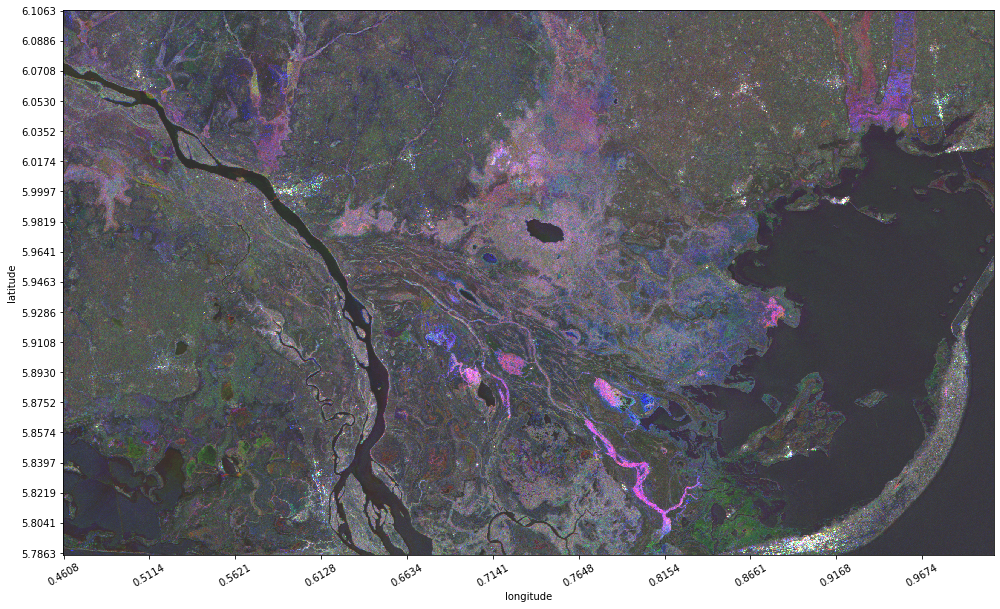

In [22]:
# Custom multi-temporal RGB - HH polarisation
# Select the data variable and scene index for each color, RGB, in order
rgb_to_data_arr_ind_map = [['hh_amp_8b', 0], ['hh_amp_8b', 3], ['hh_amp_8b', 6]]
custom_rgb(dataset, rgb_to_data_arr_ind_map, min_possible=0, max_possible=255, width=14)
plt.tight_layout()
plt.show()

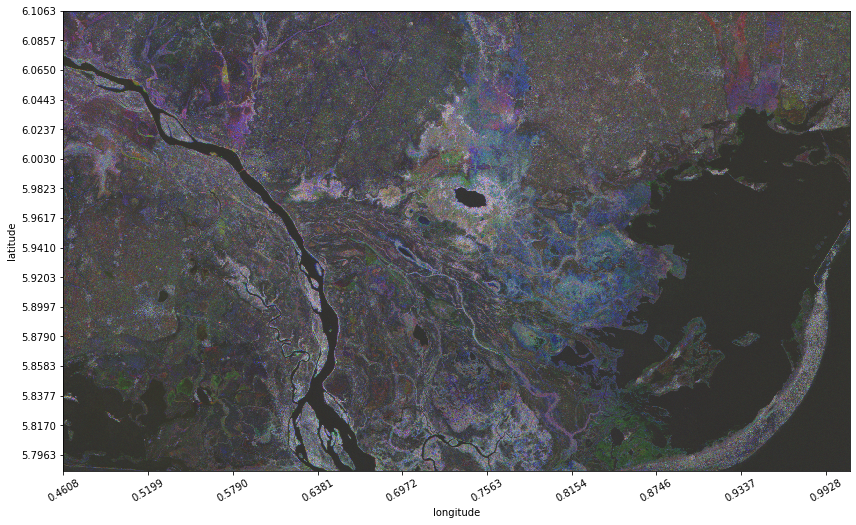

In [23]:
# Custom multi-temporal RGB - HV polarisation
# Select the data variable and scene index for each color, RGB, in order
rgb_to_data_arr_ind_map = [['hv_amp_8b', 0], ['hv_amp_8b', 3], ['hv_amp_8b', 6]]
custom_rgb(dataset, rgb_to_data_arr_ind_map, min_possible=0, max_possible=255, width=12)
plt.tight_layout()
plt.show()

## Single Date Threshold Product

In [24]:
## Threshold Plot Settings ##

# Select the single acquisition to use for threshold plot
# Choose from the indices in the table above
acq_ind_to_show = 6

# Select the variable to plot: hh, hv, or hhhv
threshold_data_var = 'hv'
assert threshold_data_var in list(dataset.data_vars), \
    f"The variable `threshold_data_var` must be one of {list(dataset.data_vars)}."

# Select the minimum and maximum values of the threshold range.
# Below the low limit = BLUE
# Above the high limit = RED
threshold_range = (750, 4000)

# Set the size of the figure.
figsize = figure_ratio(dataset.isel(time=acq_ind_to_show), fixed_width=10)

## End Settings ##

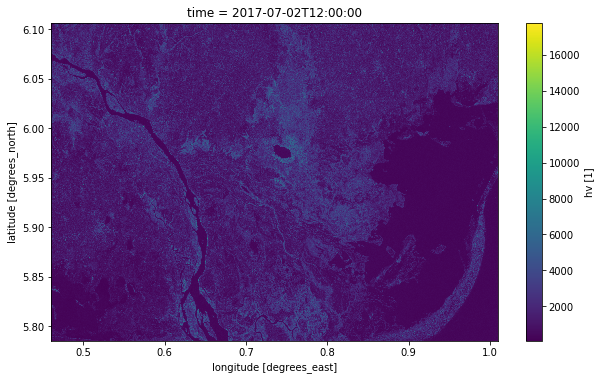

In [25]:
dataset.isel(time=acq_ind_to_show)[threshold_data_var].plot(figsize=figsize)

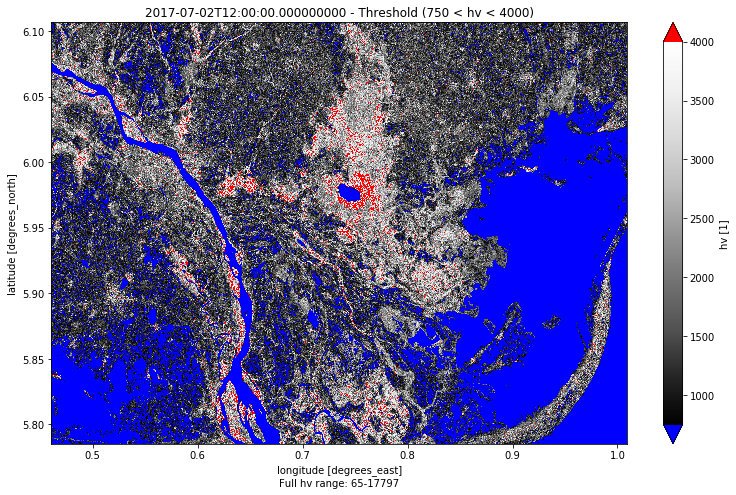

In [26]:
fig = plt.figure(figsize=figsize)
bottom, top = threshold_range
plot_threshold(dataset.isel(time=acq_ind_to_show), threshold_data_var,
               cmap_name='Greys_r', bottom=bottom, top=top, fig=fig)
plt.title(str(dataset.isel(time=acq_ind_to_show).time.values) + 
          " - Threshold ({} < {} < {})".format(bottom, threshold_data_var, top))
plt.show()

<p style= "color:blue; font-size:25px">
<b>Time Series Analyses</b>
</style>

## Box-and-Whisker and Gaussian Plots
Removed 3 blocks below from Version-3 due to memory overload issues
<br>See Version-2 to add these blocks back to the notebook

## Time Series Statistics Filter

In [27]:
def stats_filter(dataarray, statistic, filter_shape=(1,1)):
    """
    Returns a mean, median, or standard deviation filter of an `xarray.DataArray`.
    This function is more accurate than using SciPy or scikit-image methods, because
    those don't handle the extremities ideally. Specifically, only values actually 
    inside the filter should be considered, so the data is padded with NaNs.
    This function is resilient to NaNs in the data.
    
    Parameters
    ----------
    dataarray: xarray.DataArray
        The data to create a filtered version of. Must have 3 dimensions, with
        the last being 'time'.
    statistic: string
        The name of the statistic to use for the filter.
        The possible values are ['mean', 'median', 'std'].
    filter_shape: list-like of two odd, positive integers
        The shape of the filter to use. Both dimensions should have odd lengths.
    """
    filter_dims = dataarray.dims[:2]
    filter_coords = {dim: dataarray.coords[dim] for dim in filter_dims}
    filter_output = xr.DataArray(np.full(dataarray.shape[:2], np.nan), 
                                 coords=filter_coords, dims=filter_dims)
    if filter_shape == (1,1):
        agg_func_kwargs = dict(a=dataarray.values, axis=dataarray.get_axis_num('time'))
        if statistic == 'mean':
            filter_output.values[:] = np.nanmean(**agg_func_kwargs)
        elif statistic == 'median':
            filter_output.values[:] = np.nanmedian(**agg_func_kwargs)
        elif statistic == 'std':
            filter_output.values[:] = np.nanstd(**agg_func_kwargs)
    else:
        # Allocate a Numpy array containing the content of `dataarray`, but padded 
        # with NaNs to ensure the statistics are correct at the x and y extremeties of the data.
        flt_shp = np.array(filter_shape)
        del filter_shape
        shp = np.array(dataarray.shape[:2])
        pad_shp = (*(shp + flt_shp - 1), dataarray.shape[2])
        padding = (flt_shp-1)//2 # The number of NaNs from an edge of the padding to the data.
        padded_arr = np.full(pad_shp, np.nan)
        padded_arr[padding[0]:pad_shp[0]-padding[0], 
                   padding[1]:pad_shp[1]-padding[1]] = dataarray.values

        # For each point in the first two dimensions of `dataarray`...
        for i in range(filter_output.shape[0]):
            for j in range(filter_output.shape[1]):
                padded_arr_segment = padded_arr[i:i+flt_shp[0],
                                                j:j+flt_shp[1]]
                if statistic == 'mean':
                    filter_output.values[i,j] = np.nanmean(padded_arr_segment)
                elif statistic == 'median':
                    filter_output.values[i,j] = np.nanmedian(padded_arr_segment)
                elif statistic == 'std':
                    filter_output.values[i,j] = np.nanstd(padded_arr_segment)
    
    return filter_output

In [28]:
# Choose the acquisition range by their indices and then apply statistics
# The lower bound is inclusive. The upper bound is exclusive.

acq_ind_ranges = [(4, 6)]

# The `xarray.DataArray` member of `dataset` to calculate statistics for.
stats_data_arr = 'hv'

# Format `acq_ind_ranges` for xarray `isel()` and select the acquisitions.
acq_inds = np.concatenate([np.arange(*acq_ind_range) 
                           for acq_ind_range in acq_ind_ranges])
stats_data = dataset[stats_data_arr].isel(time=acq_inds)\
             .transpose('latitude', 'longitude', 'time')
vmin, vmax = stats_data.min().values, stats_data.max().values

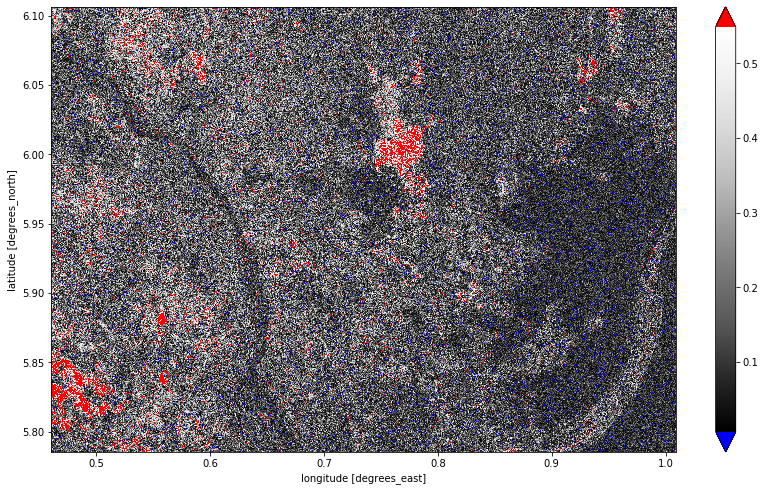

In [29]:
# Select filter type: mean, median, std
# Select the filter shape (odd integer, odd integer)

# Coefficient of Variation
filtered_sar = stats_filter(stats_data, 'std') / stats_filter(stats_data, 'mean')

th_min = np.percentile(filtered_sar.values, 2.5)
th_max = np.percentile(filtered_sar.values, 97.5)

figsize = figure_ratio(dataset.isel(time=acq_ind_to_show), fixed_width=14)
plt.figure(figsize=figsize)
filtered_sar.plot(cmap='Greys_r', 
                  vmin=th_min, 
                  vmax=th_max)
plt.show()

## Multi-Date Change Product

In [30]:
# Select TWO acquisitions to calculate a change product
# Choose from the indices in the table above

# Compare two time slices

first_acq_ind = 3
second_acq_ind = 6

# Select the variable to plot.

threshold_data_var = 'hv'

# The code will calculate the difference of the two images (Second-First)
# Define a threshold range to compare the difference of the two acquisitions
# GREY = Pixels NOT in the threshold range 
# RED = Pixels LESS than the low end of the threshold range
# GREEN = Pixels MORE than the high end of the threshold range

threshold_range = (-1000, 5000)
# May use -1500 for lower end

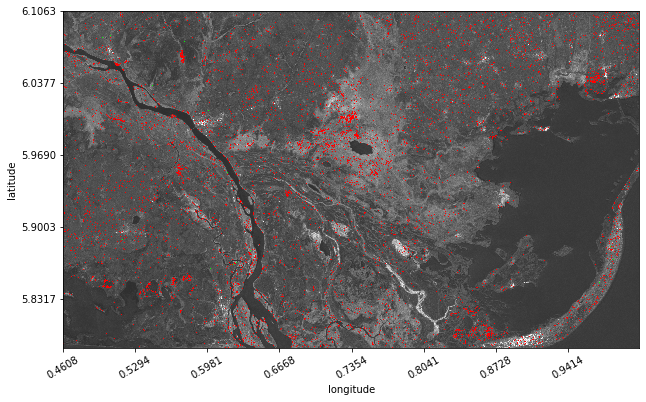

In [31]:

assert first_acq_ind >= 0 and second_acq_ind > 0, \
    "The variables `first_acq_ind` and `second_acq_ind` must be positive."
assert second_acq_ind > first_acq_ind, \
    "The variable `second_acq_ind` must be greater than `first_acq_ind`."
assert threshold_data_var in list(dataset.data_vars), \
    f"The variable `threshold_data_var` must be one of {list(dataset.data_vars)}."

## Change Product Settings ##
color_loss = np.array([255,0,0]) # backscatter decrease (RED)
color_gain = np.array([0,255,0]) # backscatter increase (GREEN)

# Set the size of the figure.
figsize = figure_ratio(dataset.isel(time=acq_ind_to_show), fixed_width=8)
## End Settings ##

fig = plt.figure(figsize=figsize)

first_acq = dataset.isel(time=first_acq_ind)
second_acq = dataset.isel(time=second_acq_ind)

composite = dataset.median('time')
change_product = second_acq[threshold_data_var] - first_acq[threshold_data_var]

below_th = change_product.values < threshold_range[0]
change_in_th = (threshold_range[0] < change_product.values) & \
               (change_product.values < threshold_range[1])
above_th = threshold_range[1] < change_product.values

rgb(composite, bands=['hh_amp_8b', 'hh_amp_8b', 'hh_amp_8b'], min_possible=0, max_possible=255, 
    paint_on_mask=[(below_th, color_loss), (above_th, color_gain)], fig=fig)

plt.show()

In [32]:
num_px_below = (change_product < threshold_range[0]).sum().values
print("Pixels below the threshold range: {} ({:.2%})".format( 
      num_px_below, num_px_below/change_product.size))
num_px_in = change_in_th.sum()
print("Pixels within the threshold range: {} ({:.2%})".format(
      num_px_in, num_px_in/change_product.size))
num_px_above = (threshold_range[1] < change_product).sum().values
print("Pixels above the threshold range: {} ({:.2%})".format(
      num_px_above, num_px_above/change_product.size))

Pixels below the threshold range: 88246 (2.47%)
Pixels within the threshold range: 3480388 (97.51%)
Pixels above the threshold range: 219 (0.01%)


## Notes on modifications made moving from ARDC to DE Africa

- Replace dc.load fuction with DE Africa dc.load fuction
- Move all module imports to start of notebook
- Removed code to view extent of datacube replaced with mapviewer that can be used to visualise spatial extent of data
- Changed rgb plot fuction to DE Africa rgb plot fuction
